# **Homework 4:** Automatic Differentiation and Neural Networks

### Collaborators

Please list anyone you discussed or collaborated on this assignment with below.

LIST COLLABORATORS HERE

I have a deep discussion wit Kelly on Q4 -- how to implement backward() and she helped me understand what and how to implement the functionality;

I also have a deep discussion with Isaac on Q9 --  how to write the new wrap_array(a) and unwrap_gradient(a). He gave a lot of hints on it;

I also used the hyperparameter provided by Maxine, i.e., lr = 0.07 and step size = 2500. It works so good!

### Course feedback

Please submit this week's course survey here: https://forms.gle/PJjGy8wrhhQnAhbb6

## Overview

In this homework we will build a tiny automatic differentiation, matrix and neural network library from scratch!

In [10]:
# Run me first!
from hw4_support import *

#### Python features
This homework makes use of a few fancy features in Python that are worth knowing about if you are unfamiliar.
- [Variable length arguments](https://book.pythontips.com/en/latest/args_and_kwargs.html) (e.g. `*args`)
- [List comprehensions](https://book.pythontips.com/en/latest/comprehensions.html#list-comprehensions) (e.g. `[a**2 for a in range(5)]`)
- [Magic methods](https://rszalski.github.io/magicmethods/) (e.g. `__add__`)


## Part 1: Reverse-mode automatic differentiation

We'll start by developing an automatic differentiation class that uses *reverse-mode automatic differentiation*, as this is what will be most useful for neural networks. 

Recall that for reverse-mode AD to work, everytime we perform an operation on one or more numbers we need to store the result of that operation as well as the *parent values* (the inputs to the operation). We also need to be able to compute the derivative of that operation. Since for every operation we need to store several pieces of data and several functions, it makes sense to define a *class* to represent the result of an operation. 

For example, if we want to make a class that represents the operation `c=a+b` our class needs several properties:
- `value`: The value of the operation (`c`)
- `parents`: The parent operations (`a` and `b`)
- `grad`: The derivative of the final loss with respect to `c` ($\frac{dL}{dc}$)
- `func`: A function that computes the operation (`a+b`)
- `grads`: A function that computes the derivatives of the operation ($\frac{dc}{da}$ and $\frac{dc}{db}$)

For this homework, we've provided the outline of such a class, called `AutogradValue`. This will be the base class for all of our possible operations and represents declaring a variable with a value (`a = 5`). This is useful because it lets us define values that we might want to find derivatives with respect to.

Let's see how this will work in practice. If we want to take derivatives we will first define the inputs using `AutogradValue`.

```{python}
a = AutogradValue(5)
b = AutogradValue(2)
```
Then we can perform whatever operations we want on these inputs:
```{python}
c = a + b
L = log(c)
```
Each of these operations will produce a new `AutogradValue` object representing the result of that operation.

Finally we can run the backward pass by running a method `backward()` (that we will write) on the outout `L`. This will compute the gradients of  `L` with respect to each input that we defined ($\frac{dL}{da}$ and $\frac{dL}{db}$). Rather than returning these derivatives, the `backward()` method will *update* the `grad` property of `a` and `b`, making it easy to access the correct derivative.

```{python}
L.backward()
dL_da = a.grad
```

We'll also be able to compute operations with non-AutogradValue numbers, but obviously won't be able to compute derivaitives with respect to these values.
```{python}
s = 4
L = s * a
dL_da = a.grad # Will work because a is an AutogradValue
dL_ds = s.grad # Will give an error because s is not an AutogradValue
```

Now that we've seen what our final produce will look like, let's define our `AutogradValue` class.

In [11]:
class AutogradValue:
    '''
    Base class for automatic differentiation operations. Represents variable delcaration.
    Subclasses will overwrite func and grads to define new operations.

    Properties:
        parents (list): A list of the inputs to the operation, may be AutogradValue or float
        args    (list): A list of raw values of each input (as floats)
        grad    (float): The derivative of the final loss with respect to this value (dL/da)
        value   (float): The value of the result of this operation
    '''

    def __init__(self, *args):
        self.parents = list(args)
        self.args = [arg.value if isinstance(arg, AutogradValue) else arg for arg in self.parents]
        self.grad = 0.
        self.value = self.forward_pass()

    def func(self, input):
        '''
        Compute the value of the operation given the inputs.
        For declaring a variable, this is just the identity function (return the input).

        Args:
            input (float): The input to the operation
        Returns:
            value (float): The result of the operation
        '''
        return input

    def grads(self, *args):
        '''
        Compute the derivative of the operation with respect to each input.
        In the base case the derivative of the identity function is just 1. (da/da = 1).

        Args:
            input (float): The input to the operation
        Returns:
            grads (tuple): The derivative of the operation with respect to each input
                            Here there is only a single input, so we return a length-1 tuple.
        '''
        return (1,)
    
    def forward_pass(self):
        # Calls func to compute the value of this operation 
        return self.func(*self.args)
    
    def __repr__(self):
        # Python magic function for string representation.
        return str(self.value)

 


Now that we've defined the framework for an operation that can be used in automatic differentiation, we need to define some actual useful operations by subclassing `AutogradValue`

#### Q1
Fill out the `func` and `grads` methods of each subclass below. Recall that `func` should always return the result of the operation and `grads` should always return a `tuple` of the derivative with respect to each input.

In [12]:
class _add(AutogradValue):
    # Addition operator (a + b)
    def func(self, a, b):
        return a + b
    
    def grads(self, a, b):
        a = a.value if isinstance(a,AutogradValue) else a
        b = b.value if isinstance(b,AutogradValue) else b
        return 1., 1.
    
class _neg(AutogradValue):
    # Negation operator (-a)
    def func(self, a):
        return -a
    
    def grads(self, a):
        a = a.value if isinstance(a,AutogradValue) else a
        return (-1.,)

class _sub(AutogradValue):
    # Subtraction operator (a - b)
    def func(self, a, b):
        return a - b
    
    def grads(self, a, b):
        a = a.value if isinstance(a,AutogradValue) else a
        b = b.value if isinstance(b,AutogradValue) else b
        return 1., -1.

class _mul(AutogradValue):
    # Multiplication operator (a * b)
    def func(self, a, b):
        return a * b
    
    def grads(self, a, b):
        a = a.value if isinstance(a,AutogradValue) else a
        b = b.value if isinstance(b,AutogradValue) else b
        return b, a

class _div(AutogradValue):
    # Division operator (a / b)
    def func(self, a, b):
        return a / b
    
    def grads(self, a, b):
        a = a.value if isinstance(a,AutogradValue) else a
        b = b.value if isinstance(b,AutogradValue) else b
        return 1/b, (-a)/(b*b)
    
class _exp(AutogradValue):
    # Exponent operator (e^a, or exp(a))
    def func(self, a):
        return np.exp(a)
    
    def grads(self, a):
        a = a.value if isinstance(a,AutogradValue) else a
        return np.exp(a),

class _log(AutogradValue):
    # (Natural) log operator (log(a))
    def func(self, a):
        return np.log(a)
    
    def grads(self, a):
        a = a.value if isinstance(a,AutogradValue) else a
        return np.divide(1, a),

Below, we'll define our basic functions and operators in terms of the operator classes we just wrote.

In [13]:
def exp(a):
    return _exp(a) if isinstance(a, AutogradValue) else math.exp(a)
def log(a):
    return _log(a) if isinstance(a, AutogradValue) else math.log(a)

# Note: Remember that above we defined a class for each type of operation
# so in this code we are overriding the basic operators for AutogradValue
# such that they construct a new object of the class corresponding to the
# given operation and return it. 
# (You don't need to everything that's happening here to do the HW)
AutogradValue.exp = lambda a: _exp(a)
AutogradValue.log = lambda a: _log(a)
AutogradValue.__add__ = lambda a, b: _add(a, b)
AutogradValue.__radd__ = lambda a, b: _add(b, a)
AutogradValue.__sub__ = lambda a, b: _sub(a, b)
AutogradValue.__rsub__ = lambda a, b: _sub(b, a)
AutogradValue.__neg__ = lambda a: _neg(a)
AutogradValue.__mul__ = lambda a, b: _mul(a, b)
AutogradValue.__rmul__ = lambda a, b: _mul(b, a)
AutogradValue.__truediv__ = lambda a, b: _div(a, b)
AutogradValue.__rtruediv__ = lambda a, b: _div(b, a)

We should now be able to use our `AutogradValue` objects as if they are numbers!

In [14]:
a = AutogradValue(5)
b = AutogradValue(2)

print((a + 5) * b)
print(log(b))

test_operators(AutogradValue)

20
0.6931471805599453
Passed!


Let confirm that we do keep the entire compuational graph for operations defined in this way. 

#### Q2
Write a function `graph_print` that takes a single argument. If the argument is an `AutogradValue` (or one of its subclasses), print its `value` property and then call `graph_print` on each of its parents. If the argument is not an `AutogradValue`, just print it. The format of printing is not important.

***Hint:** You can use the built-in Python function `isinstance` to determine if something is an `AutogradValue` or one of its subclasses. e.g. `isinstance(a, AutogradValue)`*

In [15]:
def graph_print(a):
    if isinstance(a, AutogradValue):
        print(a)
        for parent in a.parents:
            graph_print(parent)
    else:
        print(a)

a = AutogradValue(5.)
b = AutogradValue(2.)
c = log((a + 5) * b)
graph_print(c)

2.995732273553991
20.0
10.0
5.0
5.0
5
2.0
2.0


The function should print (it's ok if the numbers or order aren't exact):
```
2.995732273553991
20.0
10.0
5.0
5.0
5
2.0
2.0
```

Now in order to do automatic differentiation, we need to define how to do the backward pass. We'll start with the backward_step for a single operation.

#### Q3
Fill in the method `backward_pass` which computes a single step of the reverse pass through the computational graph (assume `self` is an `AutogradValue` instance). If `backward_pass` is called on a value `c`, the method should:
- Assume that `self.grad` contains the derivaive of the final loss with respect to `c` ($\frac{dL}{dc}$).
- Check if each parent of `c`  is an `AutogradValue`. If it is, update that parent's `grad` property to account for `c` (e.g. for parent `a`, update the value of $\frac{dL}{da}$)

**For example:** if `c` represents the result of an addition so `c = a + b`,
calling `backward_pass` on `c` will update the `grad` property of both `a` and `b`. (`a.grad` represents $\frac{dL}{da}$ and is initialized to `0`).

***Hint:** `grads` will be one of the methods we wrote in Q1. Recall that if `c` has parents `a` and `b` then `grads` method will give $\frac{dc}{da}$ and $\frac{dc}{db}$.*

In [17]:
def backward_pass(self):
    # use grads method to find gradients of the parents
    local_gradients = self.grads(*self.parents)

    for i, parent in enumerate(self.parents):
        # Check if the parent is an instance of Autograd
        if isinstance(parent, AutogradValue):
            if parent.grad == None:
                parent.grad = 0
            
            local_grad = local_gradients[i]
            parent.grad += local_grad * self.grad
    

AutogradValue.backward_pass = backward_pass

# Test our implementation
test_backward_pass(AutogradValue)

Passed!


Finally we need to define the backward method itself. We will call this on the loss value to find the derivatives of the loss with respect to each input. This means working our way backward through the sequence of operations. Remember that if `c=a+b`, then if `c.grad` is $\frac{dL}{dc}$, calling `backward_pass` on `c` will update $\frac{dL}{da}$ (`a.grad`) and $\frac{dL}{db}$ (`b.grad`).
 
The complication is that `c` may be used in multiple operations, so we can't call `backward_pass` on `c` until we've called `backward_pass` on each child operation of `c` otherwise `c.grad` won't have the correct value of $\frac{dL}{dc}$, as in this example:

```{python}
c = a + b
g = c * 2
h = c + 4
L = g * h

L.backward_pass() # Updates dL/dg and dL/dh
h.backward_pass() # Updates dL/dc

##WRONG ORDER
c.backward_pass() # Incorrect because dL/dc hasn't accounted for dL/dg
g.backward_pass()

## CORRECT ORDER
g.backward_pass() # Updates dL/dc
c.backward_pass() # Updates dL/da and dL/db
```

#### Q4
Fill in the `backward` method for `AutogradValue`. Your backward method should call `backward_pass` on each operation used to compute the loss (`self` is the loss value). Some important things to keep in mind:
- `backward_pass` should only be called **once** on each operation
- `backward_pass` must be called on **every child** of an operation before it can be called on the operation.
- You should not try to call `backward_pass` on values that aren't instances of `AutogradValue`, even though this might be stored in `operation.parents`

***Hint:** The efficiency of this method will have a large impact on the running time of later problems! We won't score efficiency in grading, but it still might be worth optimizing this function a bit.*

In [18]:
def backward(self):
    # We call backward on the loss, so dL/dL = 1
    self.grad = 1.

    backorder = []
    visited = set()

    def dfs_backward(neuron):
        if neuron in visited:
            return
        visited.add(neuron)

        for parent in neuron.parents:
            if isinstance(parent, AutogradValue):
                dfs_backward(parent)
        backorder.append(neuron)
    
    dfs_backward(self)

    for node in backorder[::-1]:
        node.backward_pass()

    # def dfs_count_children(node):
    #     if node not in visited:
    #         visited.add(node)
    #         for parent in node.parents:
    #             if isinstance(parent, AutogradValue):
    #                 child_count[parent] = child_count.get(parent, 0) + 1
    #                 dfs_count_children(parent)

    # dfs_count_children(self)

    # # Second Pass -- Process nodes with zero child count and update their parents
    # to_process = [self]

    # while to_process:
    #     node = to_process.pop()
    #     node.backward_pass()
    #     for parent in node.parents:
    #         if isinstance(parent, AutogradValue):
    #             child_count[parent] -= 1
    #             if child_count[parent] == 0:  # All children of this parent are processed
    #                 to_process.append(parent)


AutogradValue.backward = backward
# Test our implementation
test_backward(AutogradValue)

Passed!


Now we can use our `AutogradValue` class to compute derivatives!

In [19]:
a = AutogradValue(5)
b = AutogradValue(2)

L = -log(5 *b + a)
L.backward()
print(a.grad, b.grad)

-0.06666666666666667 -0.3333333333333333


If we want to train a neural network using our automatic differentiation implementation, we're going to want to be able to use numpy to do matrix operations. Fortunately, the our `AutogradValue` class is (mostly) compatible with numpy!

We can create arrays of `AutogradValue` and take derivatives as shown below:

In [20]:
a = np.array([AutogradValue(5), AutogradValue(2)])
L = np.dot(a, a)
L.backward()
print('Gradient for a', a[0].grad, a[1].grad)

Gradient for a 10.0 4.0


It would be a bit tedious to define every AutogradValue array in this way, so let's write some convinience functions to make doing automatic differentiation with numpy easier.

#### Q5
Complete the following two functions `wrap_array` and `unwrap_gradient`. 

`wrap_array` should take a numpy array of floats and return a new array where every element has been made into an `AutogradValue`. 

`unwrap_gradient` should take a numpy array of `AutogradValue` and return a new array of floats, where every element is the extracted `grad` property of the corresponding element from the original array.

Both of these functions should work on 2-D arrays (matrices) at a minimum (but more general solutions that support 1 and/or >2 dimensional arrays are also possible).

***Hint:** You can create an array from nested lists as shown above.*

In [21]:
def wrap_array(a):
    '''
    Wraps the elements of an array with AutogradValue

    Args:
        a (array of float): The array to wrap
    Returns:
        g (array of AutogradValue): An array g, such that g[i,j] = AutogradValue(a[i,j])
    '''
    # return np.array([[AutogradValue(a[i,j]) for j in range(a.shape[1])] for i in range(a.shape[0])])
    
    if isinstance(a, list):
        wrapped_list = []
        for arr in a:
            wrapped_arr = np.array([[AutogradValue(val) for val in row] for row in arr])
            wrapped_list.append(wrapped_arr)
        return wrapped_list
    else:
        return np.array([[AutogradValue(a[i, j]) for j in range(a.shape[1])] for i in range(a.shape[0])])

def unwrap_gradient(a):
    '''
    Unwraps the gradient of an array with AutogradValues

    Args:
        a (array of AutogradValue): The array to unwrap
    Returns:
        g (array of float): An array g, such that g[i,j] = a[i,j].grad
    '''
    # return np.array([[a[i,j].grad for j in range(a.shape[1])] for i in range(a.shape[0])])

    if isinstance(a, list):
        unwrapped_list = []
        for wrapped_arr in a:
            unwrapped_arr = np.array([[elem.grad for elem in row] for row in wrapped_arr])
            unwrapped_list.append(unwrapped_arr)
        return unwrapped_list
    else:
        return np.array([[a[i,j].grad for j in range(a.shape[1])] for i in range(a.shape[0])])

## Part 2: Implementing a neural network

Now that we have everything we need to apply our automatic differentiation to train a neural network!

Before we do that though, let's try out our automatic differentiation for logistic regression. Below is a slight modification of LogisticRegression implementation we saw in the last homework.

In [22]:

def sigmoid(x):
    # Computes the sigmoid function
    return 1. / (1. + np.exp(-x))

class LogisticRegression:
    def __init__(self, dims):
        '''
        Args:
            dims (int): d, the dimension of each input
        '''
        self.weights = np.zeros((dims + 1, 1))

    def prediction_function(self, X, w):
        '''
        Get the result of our base function for prediction (i.e. x^t w)

        Args:
            X (array): An N x d matrix of observations.
            w (array): A (d+1) x 1 vector of weights.
        Returns:
            pred (array): A length N vector of f(X).
        '''
        X = np.pad(X, ((0,0), (0,1)), constant_values=1.)
        return np.dot(X, w)

    def predict(self, X):
        '''
        Predict labels given a set of inputs.

        Args:
            X (array): An N x d matrix of observations.
        Returns:
            pred (array): An N x 1 column vector of predictions in {0, 1}
        '''
        return (self.prediction_function(X, self.weights) > 0)
    
    def predict_probability(self, X):
        '''
        Predict the probability of each class given a set of inputs

        Args:
            X (array): An N x d matrix of observations.
        Returns:
            probs (array): An N x 1 column vector of predicted class probabilities
        '''
        return sigmoid(self.prediction_function(X, self.weights))

    def accuracy(self, X, y):
        '''
        Compute the accuracy of the model's predictions on a dataset

        Args:
            X (array): An N x d matrix of observations.
            y (array): A length N vector of labels.
        Returns:
            acc (float): The accuracy of the classifier
        '''
        y = y.reshape((-1, 1))
        return (self.predict(X) == y).mean()

    def nll(self, X, y, w=None):
        '''
        Compute the negative log-likelihood loss.

        Args:
            X (array): An N x d matrix of observations.
            y (array): A length N vector of labels.
            w (array, optional): A (d+1) x 1 matrix of weights.
        Returns:
            nll (float): The NLL loss
        '''
        if w is None:
            w = self.weights

        y = y.reshape((-1, 1))
        xw = self.prediction_function(X, w)
        py = sigmoid((2 * y - 1) * xw)
        return -(np.log(py)).sum()
    
    def nll_gradient(self, X, y):
        '''
        Compute the gradient of the negative log-likelihood loss.

        Args:
            X (array): An N x d matrix of observations.
            y (array): A length N vector of labels.
        Returns:
            grad (array): A length (d + 1) vector with the gradient
        '''
        y = y.reshape((-1, 1))
        xw = self.prediction_function(X, self.weights)
        py = sigmoid((2 * y - 1) * xw)
        grad = ((1 - py) * (2 * y - 1)).reshape((-1, 1)) * np.pad(X, [(0,0), (0,1)], constant_values=1.)
        return -np.sum(grad, axis=0)
    
    def nll_and_grad_no_autodiff(self, X, y):
        # Compute nll_and_grad without automatic diferentiation
        return self.nll(X, y), self.nll_gradient(X, y)


#### Q6 
Write the method `nll_and_grad` for the LogisticRegression class using the automatic differentiation tools we built above. Verify that it gives a similar answer to `nll_and_grad_no_autodiff`.

In [23]:
def nll_and_grad(self, X, y):
    wrapped_weight = wrap_array(self.weights)
    nll_val = self.nll(X, y, wrapped_weight)
     
    nll_val.backward()
     
    grad_val = unwrap_gradient(wrapped_weight)
    
    return nll_val.value, grad_val

LogisticRegression.nll_and_grad = nll_and_grad

Our automatic differentiation is very inefficient (we'll fix this in the next homework!), so we'll test our model on a very small dataset.

Loss 30.61, accuracy: 0.85: 100%|██████████| 250/250 [00:00<00:00, 334.83it/s]


Model accuracy: 0.850


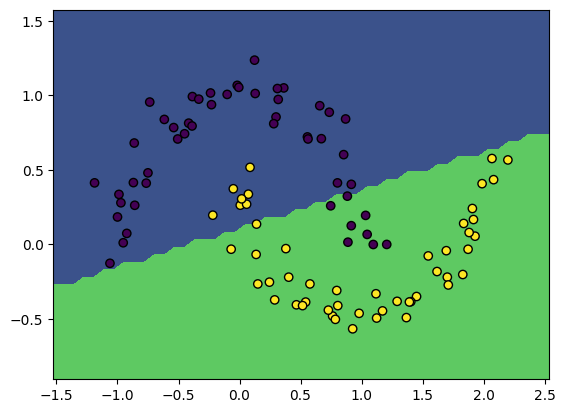

In [24]:
X, y = make_moons(100, noise=0.1)
model = LogisticRegression(2)
gradient_descent(model, X, y, lr=3e-2, steps=250)

print('Model accuracy: %.3f' % model.accuracy(X, y))
plot_boundary(model, X, y)

Now let's extend our model to be a neural network! We'll create a neural network class that extends our logistic regression class. First we'll setup the needed weight matrices.

#### Q7
Fill in the Neural Network `__init__` method below. The method should take in the input data dimension and a list of integers specifying the size of each hidden layer (the number of neurons in each layer). The function should create a list of numpy arrays of the appropriate shapes for the weight matrices. 

For example if `dims` is `2` and `hidden_sizes` is `[4, 4]`, then `self.weights` should have 3 entries of shapes `[(4x2), (4x4), (1x4)]`. This network is shown below.

<div scale=0.5><svg xmlns="http://www.w3.org/2000/svg" style="cursor: move;" viewbox="100 100 1660 899" width="600" height="400"><g transform="translate(-1450.305465592915,-694.5417988897334) scale(2.441893025338307)"><path class="link" style="stroke-width: 0.5px; stroke-opacity: 1; stroke: rgb(80, 80, 80); fill: none;" marker-end="" d="M666.6666666666666,469.5, 846.6666666666666,429.5"></path><path class="link" style="stroke-width: 0.5px; stroke-opacity: 1; stroke: rgb(80, 80, 80); fill: none;" marker-end="" d="M666.6666666666666,469.5, 846.6666666666666,469.5"></path><path class="link" style="stroke-width: 0.5px; stroke-opacity: 1; stroke: rgb(80, 80, 80); fill: none;" marker-end="" d="M666.6666666666666,469.5, 846.6666666666666,509.5"></path><path class="link" style="stroke-width: 0.5px; stroke-opacity: 1; stroke: rgb(80, 80, 80); fill: none;" marker-end="" d="M666.6666666666666,469.5, 846.6666666666666,549.5"></path><path class="link" style="stroke-width: 0.5px; stroke-opacity: 1; stroke: rgb(80, 80, 80); fill: none;" marker-end="" d="M666.6666666666666,509.5, 846.6666666666666,429.5"></path><path class="link" style="stroke-width: 0.5px; stroke-opacity: 1; stroke: rgb(80, 80, 80); fill: none;" marker-end="" d="M666.6666666666666,509.5, 846.6666666666666,469.5"></path><path class="link" style="stroke-width: 0.5px; stroke-opacity: 1; stroke: rgb(80, 80, 80); fill: none;" marker-end="" d="M666.6666666666666,509.5, 846.6666666666666,509.5"></path><path class="link" style="stroke-width: 0.5px; stroke-opacity: 1; stroke: rgb(80, 80, 80); fill: none;" marker-end="" d="M666.6666666666666,509.5, 846.6666666666666,549.5"></path><path class="link" style="stroke-width: 0.5px; stroke-opacity: 1; stroke: rgb(80, 80, 80); fill: none;" marker-end="" d="M846.6666666666666,429.5, 1026.6666666666667,429.5"></path><path class="link" style="stroke-width: 0.5px; stroke-opacity: 1; stroke: rgb(80, 80, 80); fill: none;" marker-end="" d="M846.6666666666666,429.5, 1026.6666666666667,469.5"></path><path class="link" style="stroke-width: 0.5px; stroke-opacity: 1; stroke: rgb(80, 80, 80); fill: none;" marker-end="" d="M846.6666666666666,429.5, 1026.6666666666667,509.5"></path><path class="link" style="stroke-width: 0.5px; stroke-opacity: 1; stroke: rgb(80, 80, 80); fill: none;" marker-end="" d="M846.6666666666666,469.5, 1026.6666666666667,429.5"></path><path class="link" style="stroke-width: 0.5px; stroke-opacity: 1; stroke: rgb(80, 80, 80); fill: none;" marker-end="" d="M846.6666666666666,469.5, 1026.6666666666667,469.5"></path><path class="link" style="stroke-width: 0.5px; stroke-opacity: 1; stroke: rgb(80, 80, 80); fill: none;" marker-end="" d="M846.6666666666666,469.5, 1026.6666666666667,509.5"></path><path class="link" style="stroke-width: 0.5px; stroke-opacity: 1; stroke: rgb(80, 80, 80); fill: none;" marker-end="" d="M846.6666666666666,509.5, 1026.6666666666667,429.5"></path><path class="link" style="stroke-width: 0.5px; stroke-opacity: 1; stroke: rgb(80, 80, 80); fill: none;" marker-end="" d="M846.6666666666666,509.5, 1026.6666666666667,469.5"></path><path class="link" style="stroke-width: 0.5px; stroke-opacity: 1; stroke: rgb(80, 80, 80); fill: none;" marker-end="" d="M846.6666666666666,509.5, 1026.6666666666667,509.5"></path><path class="link" style="stroke-width: 0.5px; stroke-opacity: 1; stroke: rgb(80, 80, 80); fill: none;" marker-end="" d="M846.6666666666666,549.5, 1026.6666666666667,429.5"></path><path class="link" style="stroke-width: 0.5px; stroke-opacity: 1; stroke: rgb(80, 80, 80); fill: none;" marker-end="" d="M846.6666666666666,549.5, 1026.6666666666667,469.5"></path><path class="link" style="stroke-width: 0.5px; stroke-opacity: 1; stroke: rgb(80, 80, 80); fill: none;" marker-end="" d="M846.6666666666666,549.5, 1026.6666666666667,509.5"></path><path class="link" style="stroke-width: 0.5px; stroke-opacity: 1; stroke: rgb(80, 80, 80); fill: none;" marker-end="" d="M1026.6666666666667,429.5, 1206.6666666666667,489.5"></path><path class="link" style="stroke-width: 0.5px; stroke-opacity: 1; stroke: rgb(80, 80, 80); fill: none;" marker-end="" d="M1026.6666666666667,469.5, 1206.6666666666667,489.5"></path><path class="link" style="stroke-width: 0.5px; stroke-opacity: 1; stroke: rgb(80, 80, 80); fill: none;" marker-end="" d="M1026.6666666666667,509.5, 1206.6666666666667,489.5"></path><path class="link" style="stroke-width: 0.5px; stroke-opacity: 1; stroke: rgb(80, 80, 80); fill: none;" marker-end="" d="M846.6666666666666,429.5, 1026.6666666666667,549.5"></path><path class="link" style="stroke-width: 0.5px; stroke-opacity: 1; stroke: rgb(80, 80, 80); fill: none;" marker-end="" d="M846.6666666666666,469.5, 1026.6666666666667,549.5"></path><path class="link" style="stroke-width: 0.5px; stroke-opacity: 1; stroke: rgb(80, 80, 80); fill: none;" marker-end="" d="M846.6666666666666,509.5, 1026.6666666666667,549.5"></path><path class="link" style="stroke-width: 0.5px; stroke-opacity: 1; stroke: rgb(80, 80, 80); fill: none;" marker-end="" d="M846.6666666666666,549.5, 1026.6666666666667,549.5"></path><path class="link" style="stroke-width: 0.5px; stroke-opacity: 1; stroke: rgb(80, 80, 80); fill: none;" marker-end="" d="M1026.6666666666667,549.5, 1206.6666666666667,489.5"></path><circle r="10" class="node" id="0_0" style="fill: rgb(255, 255, 255); stroke: rgb(51, 51, 51);" cx="666.6666666666666" cy="469.5"></circle><circle r="10" class="node" id="0_1" style="fill: rgb(255, 255, 255); stroke: rgb(51, 51, 51);" cx="666.6666666666666" cy="509.5"></circle><circle r="10" class="node" id="1_0" style="fill: rgb(255, 255, 255); stroke: rgb(51, 51, 51);" cx="846.6666666666666" cy="429.5"></circle><circle r="10" class="node" id="1_1" style="fill: rgb(255, 255, 255); stroke: rgb(51, 51, 51);" cx="846.6666666666666" cy="469.5"></circle><circle r="10" class="node" id="1_2" style="fill: rgb(255, 255, 255); stroke: rgb(51, 51, 51);" cx="846.6666666666666" cy="509.5"></circle><circle r="10" class="node" id="1_3" style="fill: rgb(255, 255, 255); stroke: rgb(51, 51, 51);" cx="846.6666666666666" cy="549.5"></circle><circle r="10" class="node" id="2_0" style="fill: rgb(255, 255, 255); stroke: rgb(51, 51, 51);" cx="1026.6666666666667" cy="429.5"></circle><circle r="10" class="node" id="2_1" style="fill: rgb(255, 255, 255); stroke: rgb(51, 51, 51);" cx="1026.6666666666667" cy="469.5"></circle><circle r="10" class="node" id="2_2" style="fill: rgb(255, 255, 255); stroke: rgb(51, 51, 51);" cx="1026.6666666666667" cy="509.5"></circle><text class="text" dy=".35em" style="font-size: 12px;" x="631.6666666666666" y="589.5">Input Layer ∈ ℝ²</text><text class="text" dy=".35em" style="font-size: 12px;" x="811.6666666666666" y="589.5">Hidden Layer ∈ ℝ⁴</text><text class="text" dy=".35em" style="font-size: 12px;" x="991.6666666666667" y="589.5">Hidden Layer ∈ ℝ⁴</text><circle r="10" class="node" id="2_3" style="fill: rgb(255, 255, 255); stroke: rgb(51, 51, 51);" cx="1026.6666666666667" cy="549.5"></circle><circle r="10" class="node" id="3_0" style="fill: rgb(255, 255, 255); stroke: rgb(51, 51, 51);" cx="1206.6666666666667" cy="489.5"></circle><text class="text" dy=".35em" style="font-size: 12px;" x="1171.6666666666667" y="589.5">Output Layer ∈ ℝ¹</text></g><defs><marker id="arrow" viewBox="0 -5 10 10" markerWidth="7" markerHeight="7" orient="auto" refX="40"><path d="M0,-5L10,0L0,5" style="stroke: rgb(80, 80, 80); fill: none;"></path></marker></defs></svg>

If you find it easier you could also define the weights in terms of $W^T$ instead, in which case the shapes would be: `[(2x4), (4x4), (4x1)]`. You could also consider how to add a bias term at each layer as in logistic regression (but this isn't nessecary for full credit).

The values in each array should be drawn from a normal distribution with standard deviation 1. You can create such a matrix in numpy using:

```
np.random.normal(scale=1., size=shape)
```

In [25]:
class NeuralNetwork(LogisticRegression):
    def __init__(self, dims, hidden_sizes=[]):
        self.weights = []
    
        # input layer size
        input_size = dims
    
        # For each size in hidden_sizes, create a weight matrix
        for size in hidden_sizes:
            weight_matrix = np.random.normal(scale=0.01, size=(input_size, size))
            self.weights.append(weight_matrix)
            input_size = size 
    
        output_weight_matrix = np.random.normal(scale=0.01, size=(input_size, 1))
        self.weights.append(output_weight_matrix)


Recall that for logistic regression the prediction function (before threholding or sigmoid) was $\mathbf{X}\mathbf{w}$. We now want to implement the prediction function for our neural network class. This function should perform the appropriate feature transforms and multiply by the regression weights. For a neural network with a single hidden layer this will look like:

$f(\mathbf{X}) = \sigma(\mathbf{X}\mathbf{W}_1^T)\mathbf{w}_0$

Use the **sigmoid** activation function for this problem.

For multiple layers we can also think of this a a **chain** of feature transforms:
$$\Phi_1 = \sigma(\mathbf{X}\mathbf{W}_1^T)$$
$$\Phi_2 = \sigma(\Phi_1 \mathbf{W}_2^T)$$
$$...$$
$$\Phi_l = \sigma(\Phi_{l-1} \mathbf{W}_l^T)$$
$$f(\mathbf{X}) = \Phi_l\mathbf{w}_0$$
Where $\Phi_i$ is just the variable that represents the neurons at layer $i$ (the result of the first $i$ transforms applied to $\mathbf{X}$).

#### Q8 
Implement the prediction function as described above. Note that the prediction function should use the weights passed into the `w` argument rather than `self.weights`, this will make it easier to implement the next question.

In [26]:
def prediction_function(self, X, w):
    '''
    Get the result of our base function for prediction (i.e. x^t w)

    Args:
        X (array): An N x d matrix of observations.
        w (list of arrays): A list of weight matrices
    Returns:
        pred (array): An N x 1 matrix of f(X).
    '''
    for weights in w[:-1]:  # Loop through all weight matrices
        X = sigmoid(np.dot(X, weights)) # apply sigmoid

    pred = np.dot(X, w[-1])
    return pred.reshape((-1, 1))

NeuralNetwork.prediction_function = prediction_function

test_nn_prediction_function(NeuralNetwork)

Passed!


#### Q9
Implement an `nll_and_grad` method for the `NeuralNetwork` class using your automatic differentiation implmentation to compute the gradient with respect to each weight matrix.



In [27]:
def nll_and_grad(self, X, y):
    '''
    Get the negative log-likelihood loss and its gradient

    Args:
        X (array): An N x d matrix of observations.
        y (array): A length N vector of labels
    Returns:
        nll (float): The negative log-likelihood
        grads (list of arrays): A list of the gradient of the nll with respect
                                to each value in self.weights.
    '''
    wrapped_weight = wrap_array(self.weights)
    nll_val = self.nll(X, y, wrapped_weight)
    nll_val.backward()
    grad_val = unwrap_gradient(wrapped_weight)
    
    return nll_val.value, grad_val

NeuralNetwork.nll_and_grad = nll_and_grad

We now have everything in place to train a neural network from scratch! Let's try it on our tiny dataset. Feel free to change the inputs.

***Hint**: If this give very poor results and/or runs very slowly, make sure to carefully check the shape of each operation in your code to make sure it matches your expectation.*

Loss 6.39, accuracy: 0.97: 100%|██████████| 1500/1500 [01:01<00:00, 24.43it/s]  


Model accuracy: 0.970


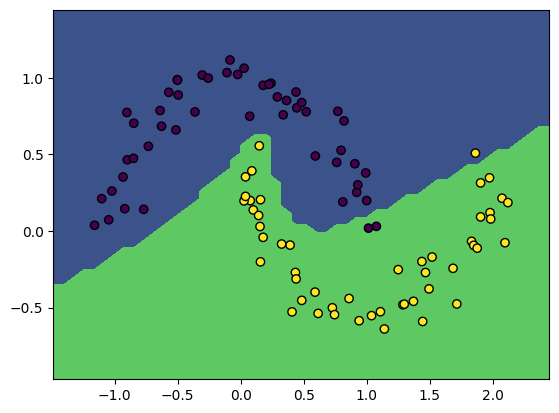

In [60]:
X, y = make_moons(100, noise=0.1)
model = NeuralNetwork(2, [5, 5])
gradient_descent(model, X, y, lr=0.07, steps=1500)

print('Model accuracy: %.3f' % model.accuracy(X, y))
plot_boundary(model, X, y)

## Part 4: Forward-mode automatic differentiation

Let's now try out the other type of automatic differentiation that we learned about: *forward-mode*. To do this we'll create a subclass of our `AutogradValue` class called `ForwardValue`.

Recall that for this version of automatic differentiaion each operation needs to keep track of the derivative of it's value with respect *each* original input. For example, in the code below the `g` object needs to store both $\frac{dg}{da}$ *and* $\frac{dg}{db}$.

```
a = ForwardValue(5)
b = ForwardValue(2)
c = a + b
g = c * 2
```

Our `ForwardValue` class will maintain a `dict` called `forward_grads` that maps each original input object to the derivative of the current value with respect to that input (so `g` will have a `dict` with keys that are the `a` and `b` **objects**). 

In the base case, when we declare a variable the derivative with respect to itself is just 1 ($\frac{da}{da}=1$)

In [30]:
class ForwardValue(AutogradValue):
    def __init__(self, *args):
        super().__init__(*args)
        self.forward_grads = {self: 1}

We see now that our `forward_pass` method needs to update `forward_grads` (e.g. to compute $\frac{dg}{da}$ and $\frac{dg}{db}$) using the `forward_grads` values of its parents (e.g. $\frac{dc}{da}$ and $\frac{dc}{db}$)

#### Q10
Implement the `forward_pass` method below for forward-mode automatic differentiation. This method should update the `foward_grads` property of the operation such that:
- `foward_grads` has an entry for every input that appears in `foward_grads` of *any* parent operation.
- If an input appears in more than 1 parent, make sure to *add* the gradients appropritately (if `g` has parents `b` and `c` then $\frac{dg}{da} = \frac{dg}{db}\frac{db}{da} + \frac{dg}{dc}\frac{dc}{da}$  )
- Parents that are not `AutogradValue` objects are ignored

If our `forward_pass` method is working correctly, we should have the following behaivior:

In [31]:
# Define our inputs as ForwardValue objects
a = ForwardValue(5)
b = ForwardValue(2)

# Perform operations
c = a * b
g = 3 * c + a


# We should have the following in the forward_grads property of c and d (note that the keys are ForwardValue objects!)
c.forward_grads = {a: 2, b: 5}  # dc/da and dc/db
g.forward_grads = {a: 3 * 2 + 1, b: 3 * 5} # dg/da = dg/dc dc/da + dg/da, dg/db = dg/dc dc/db

Implement the method below

In [32]:
def forward_pass(self):
    # Clear forward_grads if it exists
    self.forward_grads = {} 
    ## YOUR CODE HERE
    local_gradients = self.grads(*self.parents)

    for i, parent in enumerate(self.parents):
        if isinstance(parent, AutogradValue):
            local_grad = local_gradients[i]
            for key, parent_grad in parent.forward_grads.items():
                # Update the gradient for the current operation
                if key not in self.forward_grads:
                    self.forward_grads[key] = 0
                self.forward_grads[key] += local_grad * parent_grad
                
    return self.func(*self.args)

# Overwrite the AutogradValue method so that operators still work
AutogradValue.forward_pass = forward_pass
test_forward_mode(ForwardValue)

Passed!


We can now take derivates of functions much like with our reverse-mode implementation!

In [33]:
a = ForwardValue(5)
b = ForwardValue(2)
L = -log(5 *b + a)

dL_da = L.forward_grads[a]
dL_db = L.forward_grads[b]
print('dL/da = %.3f, dL/db = %.3f' % (dL_da, dL_db))

dL/da = -0.067, dL/db = -0.333


#### Q11

Complete the `ForwardModeNeuralNetwork` class that inherits from `NeuralNetwork` by implementing `nll_and_grad` to use the forward-mode implementation you just wrote!

***Hint:** Just like with the `NeuralNetwork` class from before we need to first wrap the weight elements into objects, this time of class `ForwardValue`. After wrapping we should have:*
`wrapped_w = [[ForwardValue(w[0,0]), ...], ...]` 
*Once we caluculate the loss, we should have a dictionary that maps `ForwardValue` objects to their respective derivatives: `L.forward_grads = {ForwardValue(w[0,0]): dL/dw00, ...}`. You will need to **unwrap** these derivatives as before to create a gradient array. This time the unwrap function will need to access derivative values from `L.forward_grads`.*

In [46]:
class ForwardModeNeuralNetwork(NeuralNetwork):
    def nll_and_grad(self, X, y):
        
        def forward_wrap_array(a):
            if isinstance(a, list):
                wrapped_list = []
                for arr in a:
                    wrapped_arr = np.array([[ForwardValue(val) for val in row] for row in arr])
                    wrapped_list.append(wrapped_arr)
                return wrapped_list
            else:
                return np.array([[ForwardValue(a[i, j]) for j in range(a.shape[1])] for i in range(a.shape[0])])
            
        def forward_unwrap_gradient(a):
                
                unwrapped_list = []
                for val in range(len(a)):
                    unwrapped_list.append([grad_dictionary[elem] for elem in a[val]])
                return np.array(unwrapped_list)
            
        
        wrapped_weight = forward_wrap_array(self.weights)
        nll_val = self.nll(X, y, wrapped_weight)
        grad_dictionary = nll_val.forward_grads
     
        # nll_val.forward_pass()
     
        grad_val = [forward_unwrap_gradient(weights) for weights in wrapped_weight]
    
        return nll_val.value, grad_val

We can again test it on our tiny dataset.

Loss 26.96, accuracy: 0.87: 100%|██████████| 1500/1500 [01:23<00:00, 17.87it/s]


Model accuracy: 0.870


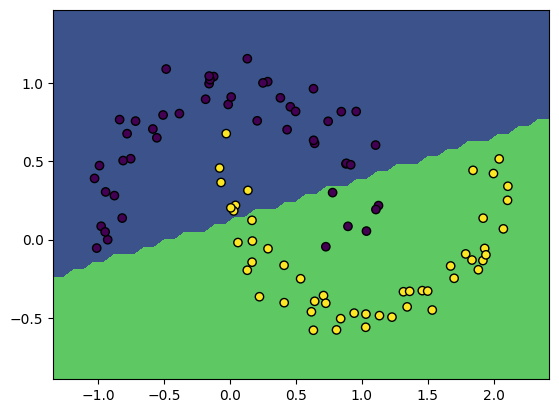

In [61]:
X, y = make_moons(100, noise=0.1)
model = ForwardModeNeuralNetwork(2, [5, 5])
gradient_descent(model, X, y, lr=0.07, steps=1500)

print('Model accuracy: %.3f' % model.accuracy(X, y))
plot_boundary(model, X, y)

#### Q12
Based on what we've learned and your experience here, why would we choose forward or reverse-mode automatic differentiation?

YOUR ANSWER HERE

I would choose reverse-mode automatic differentiation when training the neural network.

The reason is that the forward and reverse mode are chosen based on the computational graph, according to what we learned in the class. Forward mode is efficient if there are fewer input variables than output variables, where the machine can compute the derivative of each output with respect to one input at one time. However, the backward-mode automatic differentiation is more efficient when there are more input than output, in this case, a scalar loss function. 

So in our training, as we have a lot of inputs but just one output of loss, it makes reverse-mode automatic differentiation more efficient and have the better performance. Our experiments confirm this decision. That is with the architecture of (2, [5, 5]), and learning rate of 0.07, step size of 1500, we found that the overall performance of backpropagation (loss of 6.39, accruracy of 97%) is better than forward propagation (loss of 26.96, accuracy of 87%)

Also, we can find that the reverse-mode automatic differentiation in our case train faster than forward-mode one because. It will also be one reason why I will choose reverse-mode automatic differentiation (backpropagation) in this case.